# Data Loading, Cleaning and Wrangling

In [ ]:
#Need to run this to have the right path
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Installing the right stuff
!pip install -q sentencepiece
!pip install -q transformers
!pip install -q evaluate
!pip install -q rouge_score
!pip install pydot


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import evaluate
from pprint import pprint
# from transformers import T5Tokenizer, TFT5ForConditionalGeneration

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
import numpy as np
import tensorflow as tf
from tensorflow import keras

import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

from transformers import BertTokenizer, TFBertModel
import random

np.random.seed(1)


In [ ]:
#Building path and opening the files to create the dataframe
data_dir = "/content/drive/MyDrive/266 NLP - Final Project/"
data_path = data_dir+"all_the_news_SUBSET_Kaggle/"

df1 = pd.read_csv(data_path + "articles1.csv").iloc[:, 1:]
df2 = pd.read_csv(data_path + "articles2.csv").iloc[:, 1:]
df3 = pd.read_csv(data_path + "articles3.csv").iloc[:, 1:]

data = pd.concat([df1, df2, df3])

In [ ]:
### Data Characteristics
## Each id is unique to each row/headline with no duplicate articles/rows
## 142,570 total headline and articles

## 1.85% of the data doesn't have dates but I feel like it's ok to get rid of them since it's such a small sample
data[data["date"].isnull()].shape[0]/data.shape[0]
data = data[~data["date"].isnull()]

## Out of all the articles, 99.7% of them are from 2015-2017 so it might not be helpful to keep the older articles before 2015 since there are so few
data.value_counts("year").sort_index(ascending=False)
data = data[data["year"]>2014]

data = data.reset_index()

#Added word count column
data['article_wd_ct'] = data['content'].str.split().str.len() ## word count of each article

## Only subsetting for article that have at least 100 words- could do more analysis into including ones between 70-100 but the ones I've seen in that range aren't fully populated articles or poorly extracted articles
data = data[data["article_wd_ct"]>=100]

## Further subsetting the data for articles below 500 words for ease of running the models
data = data[data["article_wd_ct"]<=500]

Data Cleaning for Headlines.

A manual process done publication by publication

In [ ]:
#Atlantic
data = data.drop(data.loc[(data.publication=="Atlantic") & (data.title.str.contains("Atlantic"))].index)

#Breitbart
data.loc[((data.publication=="Breitbart") & (data.title.str.contains("- Breitbart"))), "title"] = data[(data["publication"] == "Breitbart") & (data["title"].str.contains("- Breitbart"))].title.str[:-12]
data = data.drop(data.loc[(data.publication=="Breitbart") & ( (data.title.str.contains("Breitbart")) | (data.title.str.contains("BREITBART")) )].index)

#Business Insider
data = data.drop(data.loc[(data.publication=="Business Insider") & ((data.title.str.contains("Business Insider")) | (data.title.str.contains("BUSINESS INSIDER")) )].index)

#BuzzFeed
data = data.drop(data.loc[(data.publication=="Buzzfeed News") & ((data.title.str.contains("BuzzFeed")) | (data.title.str.contains("BUZZFEED")) )].index)

#CNN
data = data.drop(data.loc[(data.publication=="CNN") & (data.title.str.contains("CNN"))].index)

#Fox News
#Fix all the aforementioned appendings. Data frame should be equal size to above, 53089, can use that to validate.
data.loc[((data.publication=="Fox News") & (data.title.str.contains("Fox News Poll:"))), "title"] = data[(data["publication"] == "Fox News") & (data["title"].str.contains("Fox News Poll:"))].title.str[15:]
data.loc[((data.publication=="Fox News") & (data.title.str.contains("Fox News Electoral Scorecard:"))), "title"] = data[(data["publication"] == "Fox News") & (data["title"].str.contains("Fox News Electoral Scorecard:"))].title.str[30:]
data.loc[((data.publication=="Fox News") & (data.title.str.contains("Fox News projects:"))), "title"] = data[(data["publication"] == "Fox News") & (data["title"].str.contains("Fox News projects:"))].title.str[19:]
data = data.drop(data.loc[(data.publication=="Fox News") & ((data.title.str.contains("Fox")) | (data.title.str.contains("FOX")) )].index)

#Guardian
data = data.drop(data.loc[(data.publication=="Guardian") & (data.title.str.contains("Guardian"))].index)

#National Review
data = data.drop(data.loc[(data.publication=="National Review") & ( (data.title.str.contains("NR ")) | (data.title.str.contains("NR:")) | (data.title.str.contains("NRI")) | (data.title.str.contains("NRO")) )].index)

#New York Post
data = data.drop(data.loc[(data.publication=="New York Post") & (data.title.str.contains("New York Post"))].index)

#New York Times
data.loc[data.publication=="New York Times", "title"] = data[data['publication'] == "New York Times"].title.str[:-21]
data = data.drop(data.loc[(data.publication=="New York Times") & (data.title.str.contains("New York Times"))].index)

#NPR
data = data.drop(data.loc[(data.publication=="NPR") & (data.title.str.contains("NPR"))].index)

#Reuters
data = data.drop(data.loc[(data.publication=="Reuters") & (data.title.str.contains("Reuters"))].index)

#Talking Points Memo
data = data.drop(data.loc[(data.publication=="Talking Points Memo") & (data.title.str.contains("TPM"))].index)

#Vox
data = data.drop(data.loc[(data.publication=="Vox") & (data.title.str.contains("Vox"))].index)

#Washington Post
data = data.drop(data.loc[(data.publication=="Washington Post") & (data.title.str.contains("Washington Post"))].index)

# Predicting the news outlet based off article

In [ ]:
final_publications = ['Breitbart', 'New York Post', 'Business Insider', 'CNN', 'Reuters', 'NPR']
final_data = data[data.publication.isin(final_publications)]

## Sampling 1000 articles from the subset of publications for equal training and testing sizes
final_data = final_data.groupby("publication").apply(lambda x: x.sample(1000, random_state=1)).reset_index(drop=True)

## Assigning numerical label to publication
pub_mapping = {j:i for i, j in enumerate(final_data.publication.unique())}
final_data["publication_id"] = final_data["publication"]
final_data = final_data.replace({"publication_id":pub_mapping})

final_data = final_data.reset_index()


In [ ]:
def convert_to_lists(data, test_size=0.2):
  articles = data["content"].values
  labels = data["publication_id"].values
  target_names = list(data["publication"].unique())
  return train_test_split(articles, labels, test_size=test_size, random_state=1), target_names

(train_texts, test_texts, train_labels, test_labels), target_names = convert_to_lists(data=final_data)
len(train_texts), len(test_texts), len(train_labels), len(test_labels), len(target_names)


(4800, 1200, 4800, 1200, 6)

In [ ]:
num = 3600
valid_texts = train_texts[num:]
valid_labels = train_labels[num:]
train_texts = train_texts[:num]
train_labels = train_labels[:num]

npvalid_labels = np.asarray(valid_labels)

In [ ]:
train_texts = list(train_texts)
valid_texts = list(valid_texts)
test_texts = list(test_texts)

In [ ]:
model_checkpoint = 'bert-base-cased'
max_length = 500

bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
## Separating the encodings
train_encodings = bert_tokenizer(train_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings = bert_tokenizer(test_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [ ]:
def create_bert_multiclass_model(checkpoint = model_checkpoint,
                                 MAX_SEQUENCE_LENGTH = max_length,
                                 num_classes = 6,
                                 hidden_size = max_length+1,
                                 dropout=0.3,
                                 learning_rate):
    bert_model.trainable = True

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    pooler_token = bert_out[1]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss="sparse_categorical_crossentropy",
                                 metrics='accuracy')

    return classification_model

In [ ]:
# with learning rate 0.00008
pooler_bert_model = create_bert_multiclass_model(checkpoint=model_checkpoint, num_classes=6, learning_rate=0.00008)
pooler_bert_model.summary()
pooler_bert_model_history = pooler_bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
                                                  train_labels,
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask],
                                                  npvalid_labels),
                                                  batch_size=8,
                                                  epochs=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 500)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 500)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 500)]                0         []                            
 tLayer)                                                                                      

In [ ]:
score = pooler_bert_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask],
                                                  test_labels)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

38/38 [==============================] - 50s 1s/step - loss: 0.2672 - accuracy: 0.9108
Test loss: 0.2671957314014435
Test accuracy: 0.9108333587646484


In [ ]:
predictions_model1 = pooler_bert_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
predictions_model1 = tf.argmax(predictions_model1, axis=-1)
predictions_model1

38/38 [==============================] - 49s 1s/step


<tf.Tensor: shape=(1200,), dtype=int64, numpy=array([1, 2, 2, ..., 0, 5, 4])>

In [ ]:
# LR = 0.00008
print(classification_report(test_labels, predictions_model1.numpy(), target_names=target_names))
cm = tf.math.confusion_matrix(test_labels, predictions_model1)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

                  precision    recall  f1-score   support

       Breitbart       0.77      0.90      0.83       201
Business Insider       0.99      1.00      1.00       194
             CNN       1.00      1.00      1.00       213
             NPR       0.89      0.96      0.92       196
   New York Post       0.85      0.74      0.79       207
         Reuters       0.99      0.87      0.93       189

        accuracy                           0.91      1200
       macro avg       0.92      0.91      0.91      1200
    weighted avg       0.91      0.91      0.91      1200



Text(220.72222222222223, 0.5, 'True')

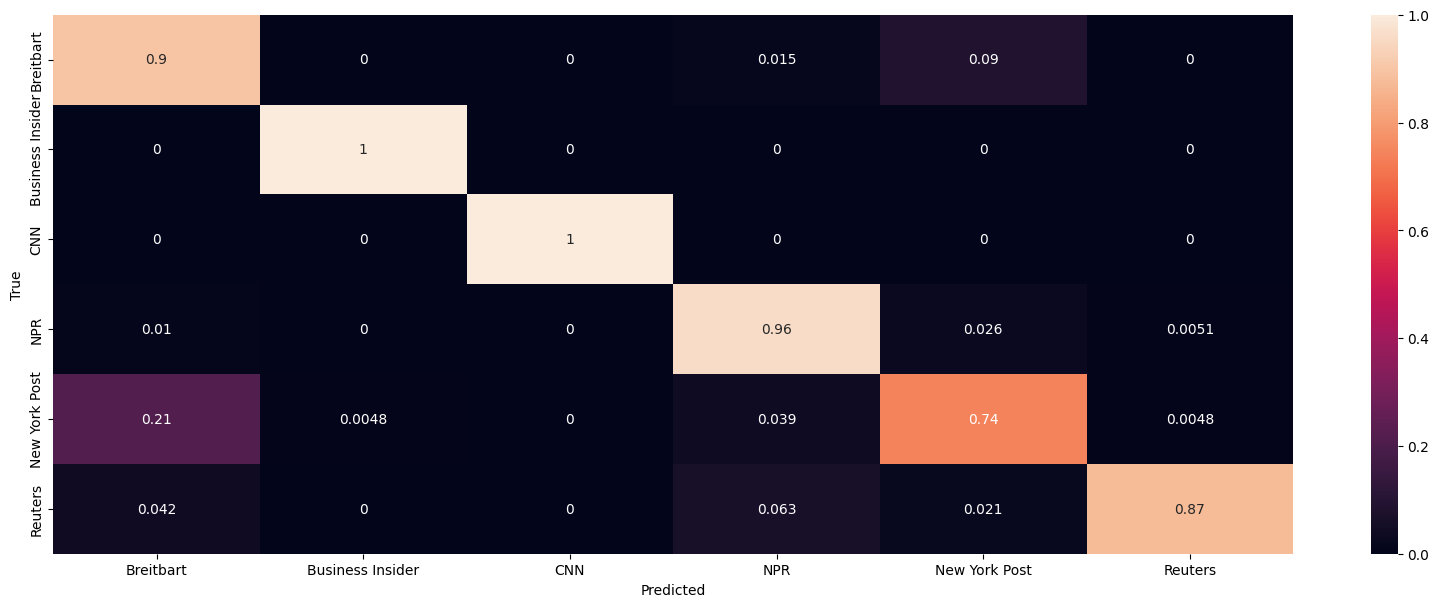

In [ ]:
# LR = 0.00008
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")